In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/hongsukyi/Lectures/main/vds/vds.csv')
df.head(2)

,Date,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate
0,2017-04-02 0:00,43,34,9,0,50.3,1.90
1,2017-04-02 0:05,45,32,13,0,58.9,1.84


In [32]:
df_spd = df.iloc[:,5:6].values

In [33]:
df_spd

array([[50.3],
       [58.9],
       [50.6],
       ...,
       [50.6],
       [59.3],
       [52.5]])

In [34]:
print(df_spd.shape)

(8064, 1)


In [35]:
max_speed = df_spd.max(); max_speed

87.8

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled_df = scaler.fit_transform(df_spd)

scaled_df

array([[0.52350699],
       [0.63278272],
       [0.52731893],
       ...,
       [0.52731893],
       [0.63786531],
       [0.55146125]])

In [8]:
look_back = 12*24

In [9]:
X = []
y = []
for i in range(len(scaled_df)-look_back-1):
    X.append(scaled_df[i:(i+look_back)])
    y.append(scaled_df[(i+look_back)])

X = np.array(X)
y = np.array(y)

In [10]:
print(X.shape, y.shape)

(7775, 288, 1) (7775, 1)


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(6220, 288, 1) (6220, 1)
(1555, 288, 1) (1555, 1)


In [12]:
neuron_1 = 32
neuron_2 = 16

In [13]:
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout

In [14]:
def model_conv1d():    
    model = Sequential([
        Conv1D(neuron_1 , kernel_size=(6,), padding='same', 
               activation='relu', input_shape = (X_train.shape[1],1)), 
        Flatten(),
        Dense(neuron_2 , activation='relu'),
        Dense(1)
    ])  
    model.compile(optimizer='adam', loss= 'mse', metrics=['mae'])
    return model

In [16]:
model = model_conv1d()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 288, 32)           224       
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 16)                147472    
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 147,713
Trainable params: 147,713
Non-trainable params: 0
_________________________________________________________________


In [17]:
from livelossplot import PlotLossesKeras

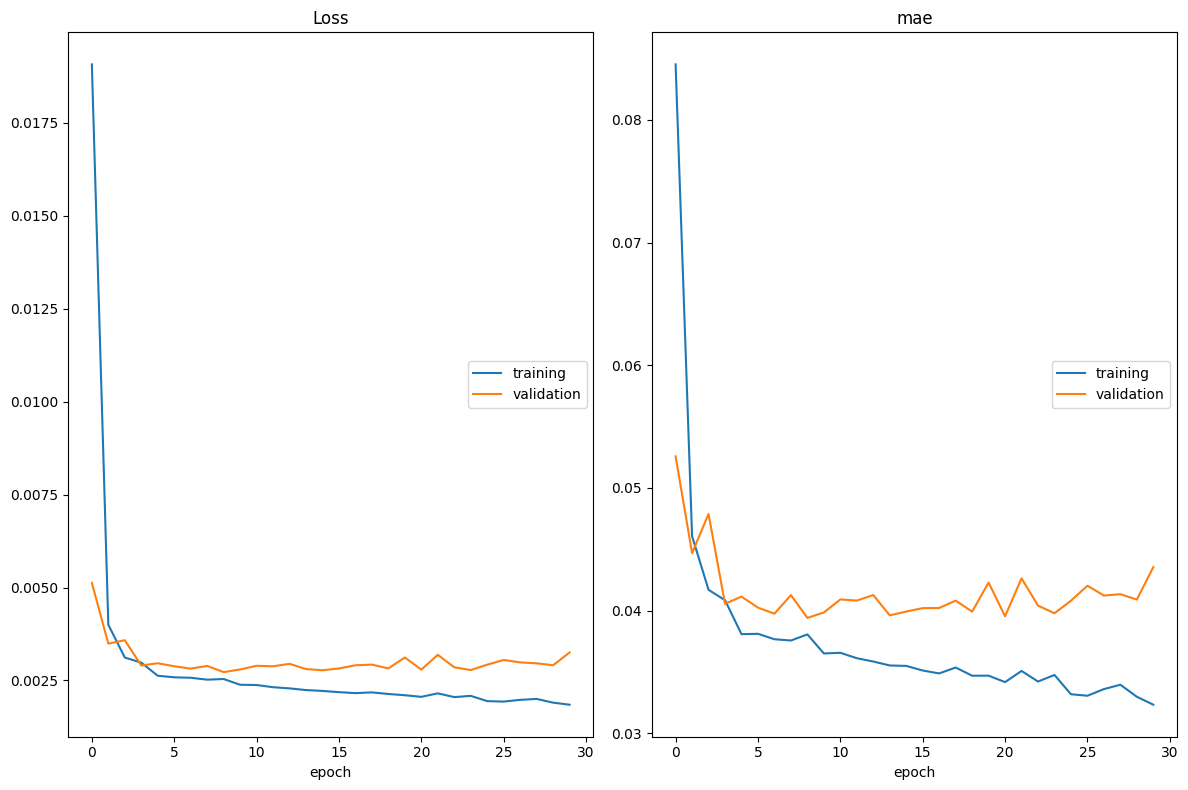

Loss
	training         	 (min:    0.002, max:    0.019, cur:    0.002)
	validation       	 (min:    0.003, max:    0.005, cur:    0.003)
mae
	training         	 (min:    0.032, max:    0.085, cur:    0.032)
	validation       	 (min:    0.039, max:    0.053, cur:    0.044)
175/175 [==============================] - 6s 33ms/step - loss: 0.0018 - mae: 0.0323 - val_loss: 0.0033 - val_mae: 0.0435


In [18]:
history = model.fit(X_train,y_train, epochs=30, validation_split=0.1, batch_size=32,callbacks=[PlotLossesKeras()])

In [19]:
mse, mae = model.evaluate(X_test,y_test, verbose=2)
print("테스트 세트의 평균 제곱 오차: {:5.4f}".format(mse))

49/49 - 1s - loss: 0.0031 - mae: 0.0409 - 1s/epoch - 25ms/step
테스트 세트의 평균 제곱 오차: 0.0031


In [37]:
# Prediction
y_pred = model.predict(X_test, verbose=0)
print(y_pred.shape,y_test.shape)

(1555, 1) (1555, 1)


In [39]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [40]:
pred_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
pred_df.head()

,Actual,Predicted
0,45.6,49.088932
1,46.4,46.138062
2,47.3,45.964275
3,49.2,44.034336
4,49.1,46.263062


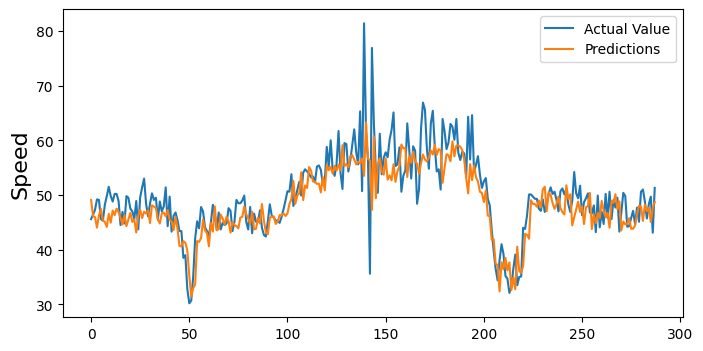

In [41]:
plt.figure(figsize=(8,4))
plt.ylabel('Speed', fontsize=16)
plt.plot(pred_df[:288])
plt.legend(['Actual Value', 'Predictions'])
plt.show()

In [42]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

49/49 [==============================] - 0s 6ms/step


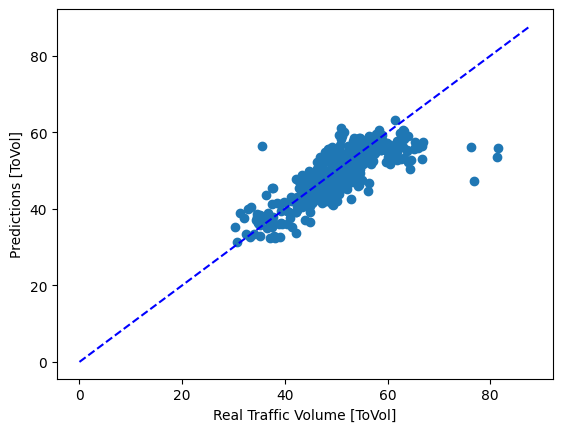

In [43]:
plt.scatter(y_test.flatten()[:576], y_pred.flatten()[:576])
plt.xlabel('Real Traffic Volume [ToVol]')
plt.ylabel('Predictions [ToVol]')
plt.plot([0, max_speed], [0, max_speed],'b--')

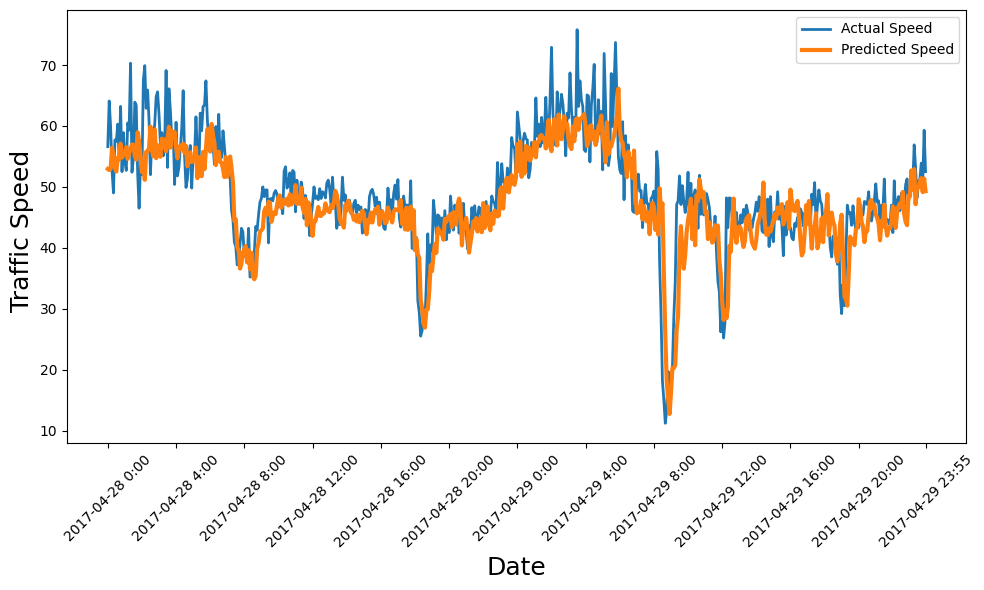

In [49]:
plt.figure(figsize=(10,6))
plt.plot(df["Date"].iloc[-576:], df_uni[-576:], linewidth= 2,  label='Actual Speed')
plt.plot(y_pred[-576:], linewidth= 3, label='Predicted Speed')
plt.xlabel("Date", size="18")
plt.ylabel("Traffic Speed ", size="18")
plt.xticks([0, 48, 96, 144,192, 240, 288, 336, 384, 432, 480, 528,575],rotation=45)
plt.tight_layout()
plt.legend()